<p style="text-align:center">
    <a href="https://skills.network/?utm_medium=Exinfluencer&utm_source=Exinfluencer&utm_content=000026UJ&utm_term=10006555&utm_id=NA-SkillsNetwork-Channel-SkillsNetworkCoursesIBMML321ENSkillsNetwork817-2022-01-01" target="_blank">
    <img src="https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/assets/logos/SN_web_lightmode.png" width="200" alt="Skills Network Logo">
    </a>
</p>


# **Course Rating Prediction using Neural Networks**


Estimated time needed: **60** minutes


In the previous labs, we have crafted several types of user and item feature vectors.  For example, given a user `i`, we may build its profile feature vector and course rating feature vector, and given an item `j`, we may create its genre vector and user enrollment vectors.



With these explicit features vectors, we can perform machine learning tasks such as calculating the similarities among users or items, finding nearest neighbors, and using dot-product to estimate a rating value.

The main advantage of using these explicit features is they are highly interpretable and yield very good performance as well. The main disadvantage is we need to spend quite some effort to build and store them.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/explicit_user_item_features.png)


Is it possible to predict a rating without building explicit feature vectors beforehand?  

Yes, as you may recall, the Non-negative Matrix Factorization decomposes the user-item interaction matrix into user matrix and item matrix, which contain the latent features of users and items and you can simply dot-product them to get an estimated rating.


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/nmf.png)


In addition to NMF, neural networks can also be used to extract the latent user and item features  In fact,  neural networks are very good at learning patterns from data and are widely used to extract latent features.  When training neural networks, it gradually captures and stores the features within its hidden layers as weight matrices and can be extracted to represent the original data.


In this lab, you will be training neural networks to predict course ratings while simultaneously extracting users' and items' latent features.


## Objectives


After completing this lab you will be able to:


* Use `tensorflow` to train neural networks to extract the user and item latent features from the hidden's layers  
* Predict course ratings with trained neural networks


----


## Prepare and setup lab environment


Install tensorflow if not installed before in your Python environment


In [1]:
%pip install tensorflow

and import required libraries:


In [2]:
%pip install pandas
%pip install matplotlib
import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from tensorflow.keras import layers
import pandas as pd

In [3]:
# also set a random state
rs = 123

### Load and processing rating dataset


In [4]:
rating_url = "https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBMSkillsNetwork-ML0321EN-Coursera/labs/v2/module_3/ratings.csv"
rating_df = pd.read_csv(rating_url)
rating_df.head()

,user,item,rating
0,1889878,CC0101EN,5
1,1342067,CL0101EN,3
2,1990814,ML0120ENv3,5
3,380098,BD0211EN,5
4,779563,DS0101EN,3


This is the same rating dataset we have been using in previous lab, which contains the three main columns: `user`, `item`, and `rating`.


Next, let's figure out how many unique users and items, their total numbers will determine the sizes of one-hot encoding vectors.


In [5]:
num_users = len(rating_df['user'].unique())
num_items = len(rating_df['item'].unique())
print(f"There are total `{num_users}` of users and `{num_items}` items")

There are total `33901` of users and `126` items


It means our each user can be represented as a `33901 x 1` one-hot vector and each item can be represented as `126 x 1` one-hot vector.


The goal is to create a neural network structure that can take the user and item one-hot vectors as inputs and outputs a rating estimation or the probability of interaction.

While training and updating the weights in the neural network, its hidden layers should be able to capture the pattern or features for each user and item. Based on this idea, we can design a simple neural network architecture like the following:


![](https://cf-courses-data.s3.us.cloud-object-storage.appdomain.cloud/IBM-ML321EN-SkillsNetwork/labs/module_4/images/embedding_feature_vector.png)


The network inputs are two one-hot encoding vectors, the blue one is for the user and the green one is for the item. Then on top of them, we added two embedding layers. Here embedding means embedding the one-hot encoding vector into a latent feature space. The embedding layer is a fully-connected layer that outputs the embedding feature vectors. For example, the user embedding layer takes `33901 x 1` one-hot vector as input and outputs a `16 x 1` embedding vector.


The embedding layer outputs two embedding vectors, which are similar to Non-negative matrix factorization. Then we could simply dot the product the user and item embedding vector to output a rating estimation.


#### Implementing the recommender neural network using tensorflow


This network architecture could be defined and implemented as a sub-class inheriting the `tensorflow.keras.Model` super class, let's call it `RecommenderNet()`.


In [6]:
class RecommenderNet(keras.Model):
    """
        Neural network model for recommendation.

        This model learns embeddings for users and items, and computes the dot product
        of the user and item embeddings to predict ratings or preferences.

        Attributes:
        - num_users (int): Number of users.
        - num_items (int): Number of items.
        - embedding_size (int): Size of embedding vectors for users and items.
    """
    def __init__(self, num_users, num_items, embedding_size=16, **kwargs):
        """
            Constructor.

            Args:
            - num_users (int): Number of users.
            - num_items (int): Number of items.
            - embedding_size (int): Size of embedding vectors for users and items.
         """
        super(RecommenderNet, self).__init__(**kwargs)
        self.num_users = num_users
        self.num_items = num_items
        self.embedding_size = embedding_size

        # Define a user_embedding vector
        # Input dimension is the num_users
        # Output dimension is the embedding size
        # A name for the layer, which helps in identifying the layer within the model.

        self.user_embedding_layer = layers.Embedding(
            input_dim=num_users,
            output_dim=embedding_size,
            name='user_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define a user bias layer
        # Bias is applied per user, hence output_dim is set to 1.
        self.user_bias = layers.Embedding(
            input_dim=num_users,
            output_dim=1,
            name="user_bias")

        # Define an item_embedding vector
        # Input dimension is the num_items
        # Output dimension is the embedding size
        self.item_embedding_layer = layers.Embedding(
            input_dim=num_items,
            output_dim=embedding_size,
            name='item_embedding_layer',
            embeddings_initializer="he_normal",
            embeddings_regularizer=keras.regularizers.l2(1e-6),
        )
        # Define an item bias layer
        # Bias is applied per item, hence output_dim is set to 1.
        self.item_bias = layers.Embedding(
            input_dim=num_items,
            output_dim=1,
            name="item_bias")

    def call(self, inputs):
        """
            Method called during model fitting.

            Args:
            - inputs (tf.Tensor): Input tensor containing user and item one-hot vectors.

            Returns:
            - tf.Tensor: Output tensor containing predictions.
        """
        # Compute the user embedding vector
        user_vector = self.user_embedding_layer(inputs[:, 0])
        # Compute the user bias
        user_bias = self.user_bias(inputs[:, 0])
        # Compute the item embedding vector
        item_vector = self.item_embedding_layer(inputs[:, 1])
        # Compute the item bias
        item_bias = self.item_bias(inputs[:, 1])
         # Compute dot product of user and item embeddings
        dot_user_item = tf.tensordot(user_vector, item_vector, 2)
        # Add all the components (including bias)
        x = dot_user_item + user_bias + item_bias
        # Apply ReLU activation function
        return tf.nn.relu(x)

### TASK: Train and evaluate the RecommenderNet()


Now it's time to train and evaluate the defined `RecommenderNet()`. First, we need to process the original rating dataset a little bit by converting the actual user ids and item ids into integer indices for `tensorflow` to creating the one-hot encoding vectors.


In [7]:
def process_dataset(raw_data):
    """
        Preprocesses the raw dataset by encoding user and item IDs to indices.

        Args:
        - raw_data (DataFrame): Raw dataset containing user, item, and rating information.

        Returns:
        - encoded_data (DataFrame): Processed dataset with user and item IDs encoded as indices.
        - user_idx2id_dict (dict): Dictionary mapping user indices to original user IDs.
        - course_idx2id_dict (dict): Dictionary mapping item indices to original item IDs.
    """

    encoded_data = raw_data.copy() # Make a copy of the raw dataset to avoid modifying the original data.

    # Mapping user ids to indices
    user_list = encoded_data["user"].unique().tolist() # Get unique user IDs from the dataset.
    user_id2idx_dict = {x: i for i, x in enumerate(user_list)} # Create a dictionary mapping user IDs to indices.
    user_idx2id_dict = {i: x for i, x in enumerate(user_list)} # Create a dictionary mapping user indices back to original user IDs.

    # Mapping course ids to indices
    course_list = encoded_data["item"].unique().tolist() # Get unique item (course) IDs from the dataset.
    course_id2idx_dict = {x: i for i, x in enumerate(course_list)} # Create a dictionary mapping item IDs to indices.
    course_idx2id_dict = {i: x for i, x in enumerate(course_list)} # Create a dictionary mapping item indices back to original item IDs.

    # Convert original user ids to idx
    encoded_data["user"] = encoded_data["user"].map(user_id2idx_dict)
    # Convert original course ids to idx
    encoded_data["item"] = encoded_data["item"].map(course_id2idx_dict)
    # Convert rating to int
    encoded_data["rating"] = encoded_data["rating"].values.astype("int")

    return encoded_data, user_idx2id_dict, course_idx2id_dict # Return the processed dataset and dictionaries mapping indices to original IDs.

In [8]:
# Process the raw dataset using the process_dataset function
# The function returns three values: encoded_data, user_idx2id_dict, and course_idx2id_dict
# encoded_data: Processed dataset with user and item IDs encoded as indices
# user_idx2id_dict: Dictionary mapping user indices to original user IDs
# course_idx2id_dict: Dictionary mapping item indices to original item IDs
encoded_data, user_idx2id_dict, course_idx2id_dict = process_dataset(rating_df)

In [9]:
encoded_data.head()

,user,item,rating
0,0,0,5
1,1,1,3
2,2,2,5
3,3,3,5
4,4,4,3


Then we can split the encoded dataset into training and testing datasets.


In [10]:
def generate_train_test_datasets(dataset, scale=True):
    """
        Splits the dataset into training, validation, and testing sets.

        Args:
        - dataset (DataFrame): Dataset containing user, item, and rating information.
        - scale (bool): Indicates whether to scale the ratings between 0 and 1. Default is True.

       Returns:
        - x_train (array): Features for training set.
        - x_val (array): Features for validation set.
        - x_test (array): Features for testing set.
        - y_train (array): Labels for training set.
        - y_val (array): Labels for validation set.
        - y_test (array): Labels for testing set.
    """

    min_rating = min(dataset["rating"]) # Get the minimum rating from the dataset
    max_rating = max(dataset["rating"]) # Get the maximum rating from the dataset

    dataset = dataset.sample(frac=1, random_state=42) # Shuffle the dataset to ensure randomness
    x = dataset[["user", "item"]].values # Extract features (user and item indices) from the dataset
    if scale:
        # Scale the ratings between 0 and 1 if scale=True
        y = dataset["rating"].apply(lambda x: (x - min_rating) / (max_rating - min_rating)).values
    else:
        # Otherwise, use raw ratings
        y = dataset["rating"].values

    # Assuming training on 80% of the data and testing on 10% of the data
    train_indices = int(0.8 * dataset.shape[0])
    test_indices = int(0.9 * dataset.shape[0])
    # Assigning subsets of features and labels for each set
    x_train, x_val, x_test, y_train, y_val, y_test = (
        x[:train_indices], # Training features
        x[train_indices:test_indices], # Validation features
        x[test_indices:], # Testing features
        y[:train_indices], # Training labels
        y[train_indices:test_indices], # Validation labels
        y[test_indices:], # Testing labels
    )
    return x_train, x_val, x_test, y_train, y_val, y_test # Return the training, validation, and testing sets

In [11]:
x_train, x_val, x_test, y_train, y_val, y_test = generate_train_test_datasets(encoded_data)

If we take a look at the training input data, it is simply just a list of user indices and item indices, which is a dense format of one-hot encoding vectors.


In [12]:
user_indices = x_train[:, 0]
user_indices

array([ 8376,  7659, 10717, ...,  3409, 28761,  4973])

In [13]:
item_indices = x_train[:, 1]
item_indices

array([12, 29,  3, ..., 18, 19, 17])

The training output labels are a list of 0s and 1s indicating if the user has completed a course or not.


In [14]:
y_train

array([0., 0., 0., ..., 0., 1., 0.])

Then we can choose a small embedding vector size to be 16 and create a `RecommenderNet()` model to be trained.


In [15]:
embedding_size = 16
model = RecommenderNet(num_users, num_items, embedding_size)

_TODO: Train the RecommenderNet() model_


Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 10ms/step - loss: 0.2355 - root_mean_squared_error: 0.4826 - val_loss: 0.1781 - val_root_mean_squared_error: 0.4214
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 38s 9ms/step - loss: 0.1739 - root_mean_squared_error: 0.4162 - val_loss: 0.1784 - val_root_mean_squared_error: 0.4214
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.1593 - root_mean_squared_error: 0.3980 - val_loss: 0.1794 - val_root_mean_squared_error: 0.4222
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 26s 9ms/step - loss: 0.1538 - root_mean_squared_error: 0.3906 - val_loss: 0.1839 - val_root_mean_squared_error: 0.4271
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 39s 8ms/step - loss: 0.1525 - root_mean_squared_error: 0.3885 - val_loss: 0.1862 - val_root_mean_squared_error: 0.4293
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 42s 9ms/step - loss: 0.1505 - root_mean_squared_error: 0.3854 - val_loss: 0.1902 - val_root_mean_squared_error: 0.4336
Epoch 7/10
2917/2917 ━━━━━━━━━━━━

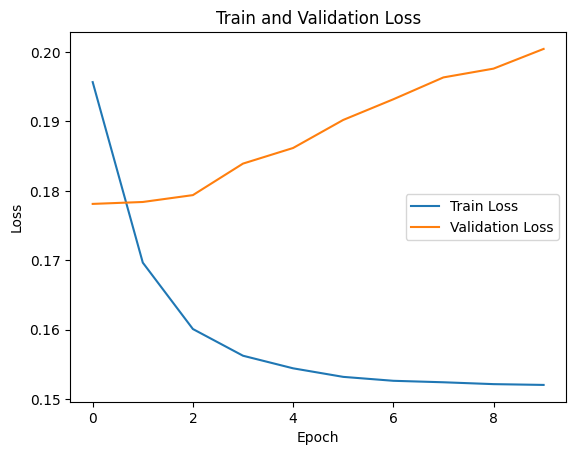

In [16]:
## WRITE YOUR CODE HERE:

# Define the embedding size
embedding_size = 16

# Create the RecommenderNet model
model = RecommenderNet(num_users, num_items, embedding_size)

# Compile the model
model.compile(loss=tf.keras.losses.MeanSquaredError(),
              optimizer=keras.optimizers.Adam(),
              metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
history = model.fit(x=x_train, y=y_train,
                    validation_data=(x_val, y_val),
                    epochs=10, batch_size=64, verbose=1)


# save the model
model.save("recommender_model.h5")

# Plot the train and validation loss
plt.plot(history.history["loss"], label="Train Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.title("Train and Validation Loss")
plt.legend()
plt.show()

<details>
    <summary>Click here for Hints</summary>
    
When you are fitting a model, dont forget to specify the parameters: `x=x_train, y=y_train`, as well as `batch_size=64`, number of `epochs=10` and of course `validation_data=(x_val, y_val)` you can also define `verbose = 1` which will show you an animated progress for the training progress for each epoch.
    
* You can set  `history = model.fit()` which will give you a "loss" dataframe which will be very useful for ploting the train and validation loss. To plot it, use plt.plot() with `history.history["loss"]` as its parameter for train loss and `history.history["val_loss"]` for validation loss.


_TODO:_ Evaluate the trained model


In [17]:
### WRITE YOUR CODE HERE

### - call model.evaluate() to evaluate the model
test_loss, test_rmse = model.evaluate(x=x_test, y=y_test)

print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)

730/730 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - loss: 0.1979 - root_mean_squared_error: 0.4416
Test Loss: 0.19808954000473022
Test RMSE: 0.441770076751709


<details>
    <summary>Click here for Hints</summary>
    
Use `x_test, y_test` as parameters for `model.evaluate()`


### Extract the user and item embedding vectors as latent feature vectors


Now, we have trained the `RecommenderNet()` model and it can predict the ratings with relatively small RMSE.

If we print the trained model then we can see its layers and their parameters/weights.


In [18]:
model.summary()

Model: "recommender_net_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ user_embedding_layer            │ (None, 16)             │       542,416 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ user_bias (Embedding)           │ (None, 1)              │        33,901 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_embedding_layer            │ (None, 16)             │         2,016 │
│ (Embedding)                     │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ item_bias (Embedding)           │ (None, 1)              │           126 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 1,735,379 (6.62 MB)

 Trainable params: 578,459 (2.21 MB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 1,156,920 (4.41 MB)

In the `RecommenderNet`, the `user_embedding_layer` and `item_embedding_layer` layers contain the trained weights. Essentially, they are the latent user and item features learned by `RecommenderNet` and will be used to predict the interaction. As such, while training the neural network to predict rating, the embedding layers are simultaneously trained to extract the embedding user and item features.


We can easily get the actual weights using `model.get_layer().get_weights()` methods


In [19]:
# User features
user_latent_features = model.get_layer('user_embedding_layer').get_weights()[0]
print(f"User features shape: {user_latent_features.shape}")

User features shape: (33901, 16)


In [20]:
user_latent_features[0]

array([-0.04582114,  0.00260961,  0.10283856,  0.0579473 , -0.02350392,
       -0.09334338, -0.24611615, -0.09898353, -0.04653908, -0.09578124,
        0.01430243,  0.0332623 ,  0.02947195, -0.04915086, -0.0321647 ,
       -0.06071617], dtype=float32)

In [21]:
item_latent_features = model.get_layer('item_embedding_layer').get_weights()[0]
print(f"Item features shape: {item_latent_features.shape}")

Item features shape: (126, 16)


In [22]:
item_latent_features[0]

array([ 0.0151382 ,  0.00767057,  0.01007066,  0.01305242,  0.00889021,
       -0.02982958,  0.01693166, -0.00472601,  0.02599005,  0.00140586,
       -0.028147  , -0.01757383,  0.01017553, -0.0259775 , -0.01025378,
       -0.00802214], dtype=float32)

Now, each user of the total 33901 users has been transformed into a 16 x 1 latent feature vector and each item of the total 126 has been transformed into a 16 x 1 latent feature vector.


### TASK (Optional): Customize the RecommenderNet to potentially improve the model performance


The pre-defined `RecommenderNet()` is a actually very basic neural network, you are encouraged to customize it to see if model prediction performance will be improved. Here are some directions:
- Hyperparameter tuning, such as the embedding layer dimensions
- Add more hidden layers
- Try different activation functions such as `ReLu`


In [23]:
## WRITE YOUR CODE HERE

## Update RecommenderNet() class

## compile and fit the updated model

## evaluate the updated model

class CustomRecommenderNet(tf.keras.Model):
    def __init__(self, num_users, num_items, embedding_size, hidden_units):
        super(CustomRecommenderNet, self).__init__()

        self.user_embedding_layer = layers.Embedding(num_users, embedding_size)
        self.user_bias = layers.Embedding(num_users, 1)

        self.item_embedding_layer = layers.Embedding(num_items, embedding_size)
        self.item_bias = layers.Embedding(num_items, 1)

        self.hidden_layers = [layers.Dense(units, activation='relu') for units in hidden_units]

        self.output_layer = layers.Dense(1)

    def call(self, inputs):
        user_indices, item_indices = inputs

        user_vector = self.user_embedding_layer(user_indices)
        user_bias = self.user_bias(user_indices)

        item_vector = self.item_embedding_layer(item_indices)
        item_bias = self.item_bias(item_indices)

        dot_user_item = tf.reduce_sum(tf.multiply(user_vector, item_vector), axis=1, keepdims=True)

        x = dot_user_item + user_bias + item_bias

        for layer in self.hidden_layers:
            x = layer(x)

        return self.output_layer(x)

# Define hyperparameters
embedding_size = 32
hidden_units = [64, 32]

# Create the custom model
custom_model = CustomRecommenderNet(num_users, num_items, embedding_size, hidden_units)

# Compile the model
custom_model.compile(loss=tf.keras.losses.MeanSquaredError(),
                     optimizer=tf.keras.optimizers.Adam(),
                     metrics=[tf.keras.metrics.RootMeanSquaredError()])

# Train the model
custom_history = custom_model.fit(x=[x_train[:, 0], x_train[:, 1]], y=y_train,
                                  validation_data=([x_val[:, 0], x_val[:, 1]], y_val),
                                  epochs=10, batch_size=64, verbose=1)

# Evaluate the model
test_loss, test_rmse = custom_model.evaluate(x=[x_test[:, 0], x_test[:, 1]], y=y_test)
print("Test Loss:", test_loss)
print("Test RMSE:", test_rmse)

Epoch 1/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 34s 11ms/step - loss: 0.1744 - root_mean_squared_error: 0.4171 - val_loss: 0.1676 - val_root_mean_squared_error: 0.4094
Epoch 2/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 42s 11ms/step - loss: 0.1634 - root_mean_squared_error: 0.4043 - val_loss: 0.1696 - val_root_mean_squared_error: 0.4119
Epoch 3/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 32s 11ms/step - loss: 0.0998 - root_mean_squared_error: 0.3158 - val_loss: 0.2022 - val_root_mean_squared_error: 0.4496
Epoch 4/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0481 - root_mean_squared_error: 0.2192 - val_loss: 0.2294 - val_root_mean_squared_error: 0.4789
Epoch 5/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 41s 11ms/step - loss: 0.0266 - root_mean_squared_error: 0.1631 - val_loss: 0.2382 - val_root_mean_squared_error: 0.4880
Epoch 6/10
2917/2917 ━━━━━━━━━━━━━━━━━━━━ 31s 11ms/step - loss: 0.0173 - root_mean_squared_error: 0.1316 - val_loss: 0.2456 - val_root_mean_squared_error: 0.4955
Epoch 7/10
2917/2917 ━━━━━━━

### Summary


In this lab, you have learned and practiced predicting course ratings using neural networks. With a predefined and trained neural network, we can extract or embed users and items into latent feature spaces and further predict the interaction between a user and an item with the latent feature vectors.


## Authors


[Yan Luo](https://www.linkedin.com/in/yan-luo-96288783/)


### Other Contributors


```toggle## Change Log
```


```toggle|Date (YYYY-MM-DD)|Version|Changed By|Change Description|
```
```toggle|-|-|-|-|
```
```toggle|2021-10-25|1.0|Yan|Created the initial version|
```


Copyright © 2021 IBM Corporation. All rights reserved.
